# Weather EDA

In this notebook the data on weather is explored by having a closer look at statistics and visualising it.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time, timedelta
from calendar import monthrange
from calendar import month_name
import matplotlib.patches as patches

import missingno as msgo

In [3]:
df = pd.read_csv('../data/df_weather_2012_2022.csv')

In [4]:
df.head()

,datetime,wind_dir,sun_minutes,rel_humid,cloud_cover,t_air,t_surface,precip,wind_speed
0,2012-01-01 00:30:00,141.68,0.0,93.25,8.50,4.69,3.08,NaN,1.54
1,2012-01-01 01:30:00,144.44,0.0,93.40,9.00,4.86,3.32,NaN,1.70
2,2012-01-01 02:30:00,133.33,0.0,93.73,9.00,5.38,3.69,NaN,2.07
3,2012-01-01 03:30:00,135.93,0.0,93.70,9.00,5.88,4.07,NaN,1.85
4,2012-01-01 04:30:00,156.67,0.0,93.65,8.08,6.81,5.04,NaN,2.30


The data contains several columns, each containing one meteorological variable. Apparently there are missing values, so these are visualized by using Missigno.

<Axes: >

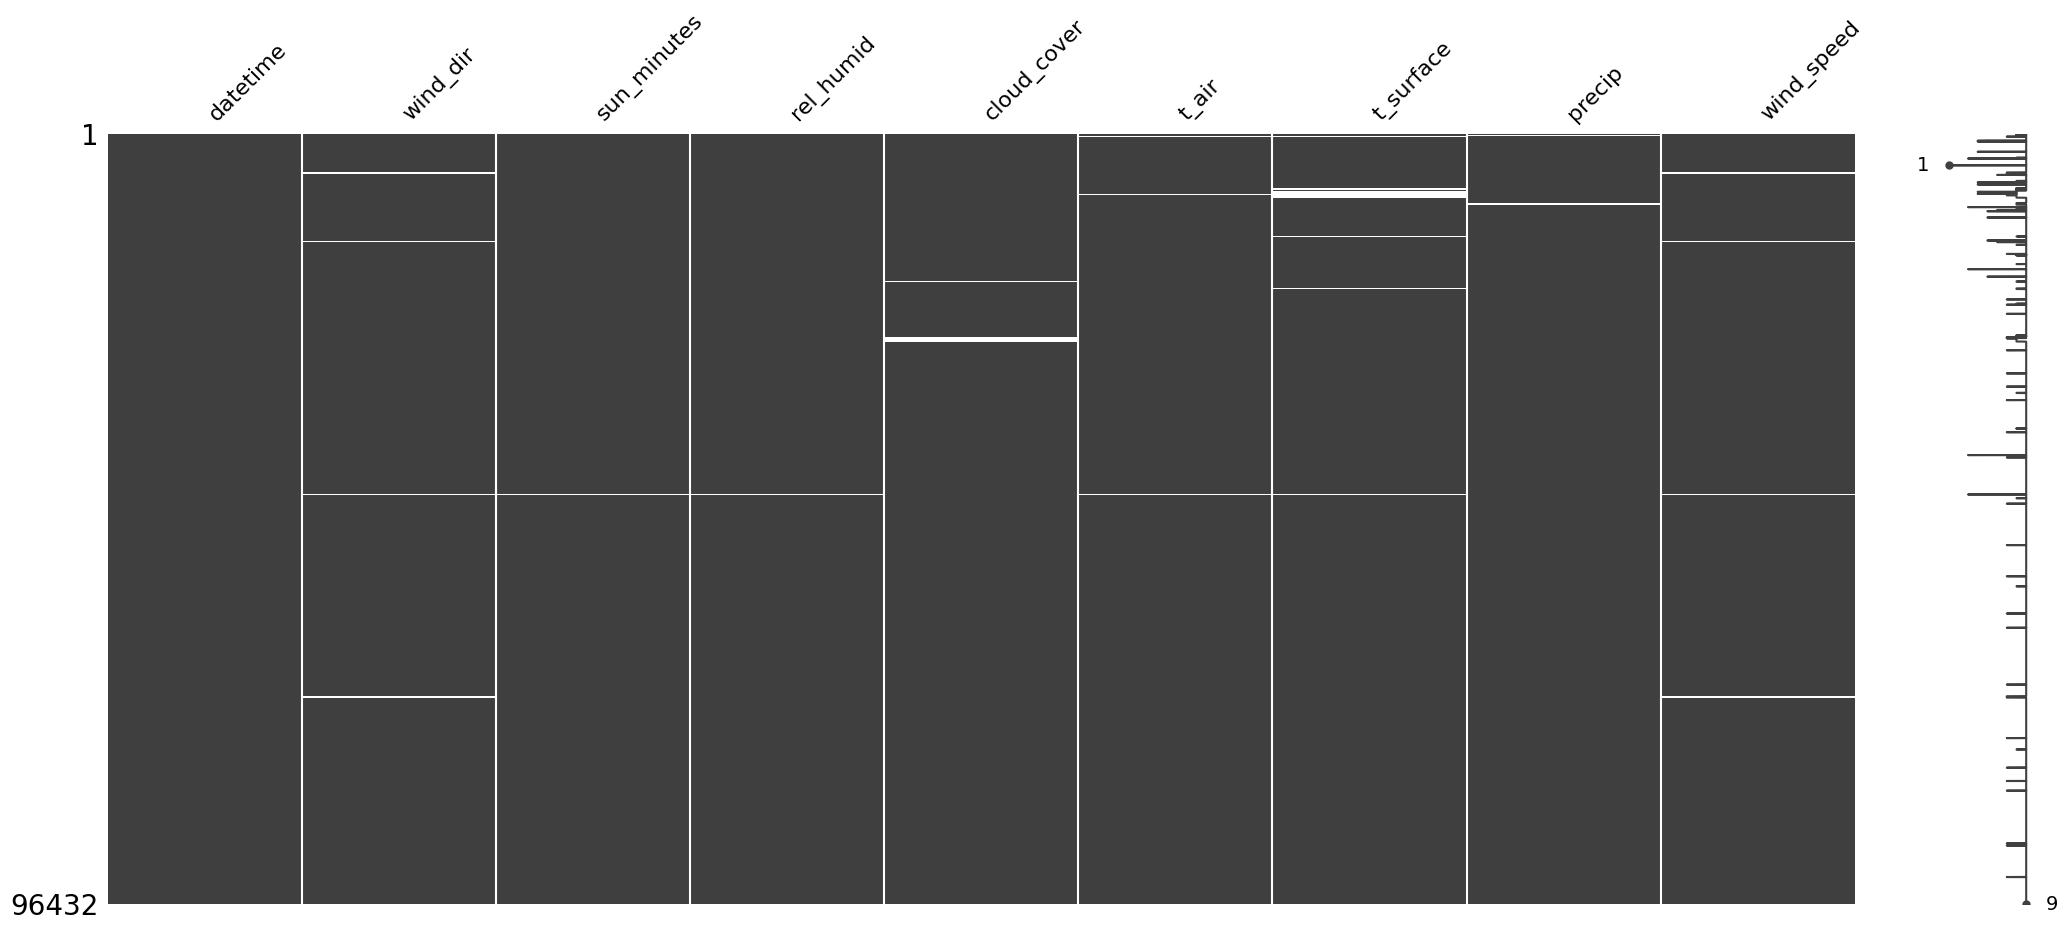

In [5]:
#missign values
msgo.matrix(df)

For additional evaluation, several columns regarding the date (weekday, month etc.) are added to the dataframe.

In [6]:
# Create working copy of dataframe
data_df = df.copy()

# Convert timestamp to datetime object
# Extract additional features from timestamp column
data_df = data_df.assign(
    datetime = lambda x: pd.to_datetime(x['datetime']), 
    date = lambda x: x['datetime'].dt.date,
    year = lambda x: x['datetime'].dt.year,
    month = lambda x: x['datetime'].dt.month,
    day = lambda x: x['datetime'].dt.day,
    dayofyear = lambda x: x['datetime'].dt.dayofyear,
    hour = lambda x: x['datetime'].dt.hour,
    weekday = lambda x: x['datetime'].dt.weekday, # Monday = 0
)

data_df.head()

,datetime,wind_dir,sun_minutes,rel_humid,cloud_cover,t_air,t_surface,precip,wind_speed,date,year,month,day,dayofyear,hour,weekday
0,2012-01-01 00:30:00,141.68,0.0,93.25,8.50,4.69,3.08,NaN,1.54,2012-01-01,2012,1,1,1,0,6
1,2012-01-01 01:30:00,144.44,0.0,93.40,9.00,4.86,3.32,NaN,1.70,2012-01-01,2012,1,1,1,1,6
2,2012-01-01 02:30:00,133.33,0.0,93.73,9.00,5.38,3.69,NaN,2.07,2012-01-01,2012,1,1,1,2,6
3,2012-01-01 03:30:00,135.93,0.0,93.70,9.00,5.88,4.07,NaN,1.85,2012-01-01,2012,1,1,1,3,6
4,2012-01-01 04:30:00,156.67,0.0,93.65,8.08,6.81,5.04,NaN,2.30,2012-01-01,2012,1,1,1,4,6


For the usage within this project, the daily mean temperature was chosen to be relevant. This variable is created and visualized in a plot showing the mean average temperature annual cycle.

In [7]:
# Aggregate airtemp by day
data_df_ta = data_df \
    .groupby(['date', 'year', 'month', 'day', 'dayofyear'], as_index=False)\
    .agg({'t_air': np.mean}) \
    .set_index('date')

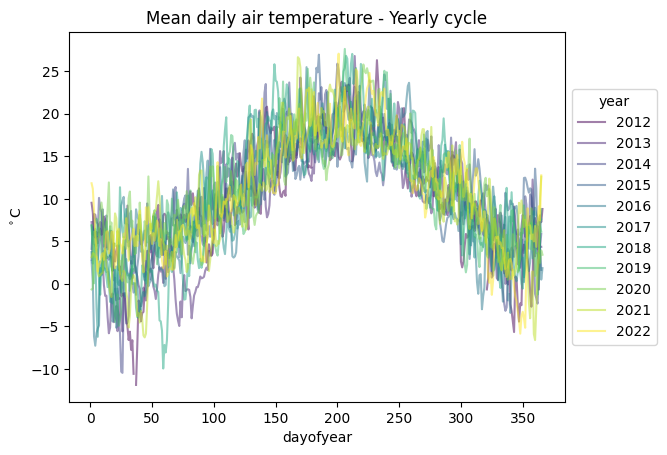

In [8]:
# Plot yearly seasonality
fig, ax = plt.subplots() 

pd.pivot_table(data=data_df_ta[['year', 'dayofyear', 't_air']], index='dayofyear', columns='year') \
    ['t_air'] \
    .plot(cmap='viridis', alpha=0.5, ax=ax)

ax.legend(title='year', loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Mean daily air temperature - Yearly cycle', ylabel=r'$^\circ$C');

Daily sunshine is calculated as a sum, its annual distribution visualized.


In [9]:
# Aggregate sunshine by day
data_df_sun = data_df \
    .groupby(['date', 'year', 'month', 'day', 'dayofyear'], as_index=False)\
    .agg({'sun_minutes': np.sum}) \
    .set_index('date')

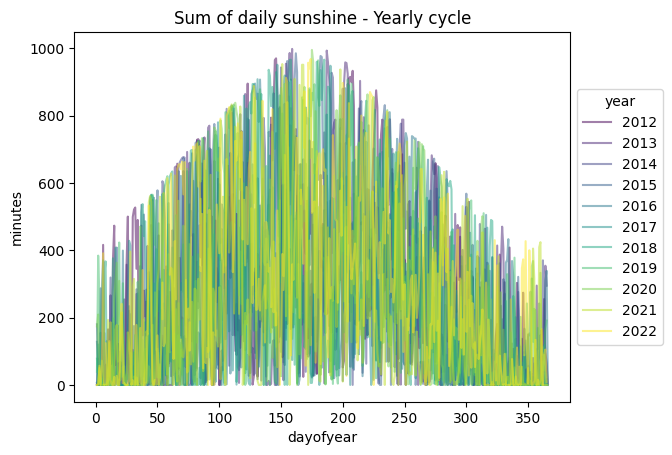

In [10]:
# Plot yearly seasonality
fig, ax = plt.subplots() 

pd.pivot_table(data=data_df_sun[['year', 'dayofyear', 'sun_minutes']], index='dayofyear', columns='year') \
    ['sun_minutes'] \
    .plot(cmap='viridis', alpha=0.5, ax=ax)

ax.legend(title='year', loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Sum of daily sunshine - Yearly cycle', ylabel='minutes');

A polar plot is a more convenient way to look at the annual cycle. The following figure shows the average daily sunshine for each day of the year (solid line) as well as the range within the years 2012 to 2022 (hatching).

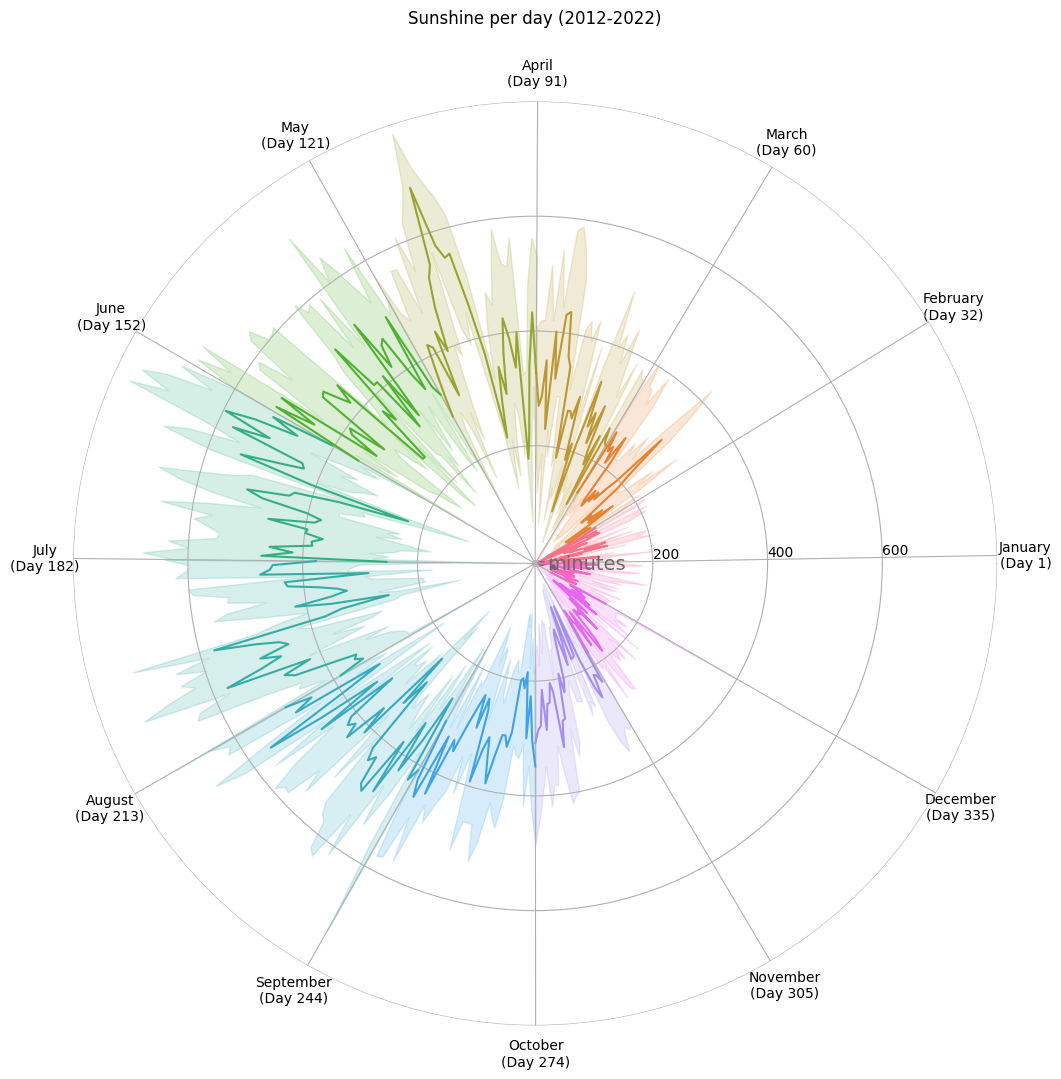

In [40]:
# Polar plot for seasonality 
ax = plt.subplot(111, projection='polar')

# Convert and plot data
data_df_sun \
    .assign(day_of_year_cyclic = lambda x: x['dayofyear'].transform(lambda x: 2*np.pi*x/365.25)) \
    .pipe((sns.lineplot, 'data'), 
        x='day_of_year_cyclic', 
        y='sun_minutes', 
        hue='month',
        palette=sns.color_palette("husl", 12),
        ax=ax
    )

fancy_plot=True     #this is only to make the plot more beautiful. If you just want to see how the data looks without the adjustments to the plot set fancy_plot to False
if(fancy_plot): 
    days_per_month=[0] + [monthrange(2021, i)[1] for i in range(1,12)]      #findout how many days each month has ()
    month_start=np.cumsum(days_per_month) +1                                #add 1 to start at 0 instead of 0, take the cumsum to get ech months starting day
    month_start_theta=[i *2 * np.pi / 365.25 for i in month_start]          #turn start day into an angle (in rad), use 365.25 as the average length of a year

    month_label=[month_name[i] for i in range(1,13)]
    month_label_long=[label+'\n(Day ' +str(month_start[ind]) +')' for ind,label in enumerate(month_label)]

    ax.set_title('Sunshine per day (2012-2022)', va='bottom',pad=22);
    ax.spines.clear()
    
    ax.set_xlabel('')
    ax.set_xticks(month_start_theta)
    ax.set_xticklabels(month_label_long)
    
    ax.set_ylabel('')    
    ax.set_ylim(-5,28)
    ax.set_yticks(yt:=[0,200,400,600,800])
    ax.set_yticklabels(['','200','400','600',''], rotation = 45)

    #Arrows / Annotations
    style = "Simple, tail_width=0.5, head_width=4, head_length=8"
    kw = dict(arrowstyle=style, color="dimgrey")
    ax.set_rlabel_position(1) 
    #ax.text(13*2*np.pi/360,24,"Days",size=14,color='dimgrey',rotation=-80,va='center')
    ax.text(-3*2*np.pi/360,16,"minutes",size=14,color='dimgrey',rotation=-0,va='center')
    a1 = patches.FancyArrowPatch((1*np.pi/180, -5), (1*np.pi/180, 26), **kw)

    a2 = patches.FancyArrowPatch((1*np.pi/180, 24), (25*np.pi/180, 24),
                                connectionstyle=f"arc3,rad={0.105}", **kw)
    
    ax.add_patch(a1)
    ax.add_patch(a2)


    ax.set_rorigin(-5)
    ax.xaxis.set_tick_params(which='major',pad=10)
    ax.get_legend().remove()
    #ax.legend(labels=month_label,ncol=2,facecolor='white',edgecolor='white',bbox_to_anchor=(1.1, 1.1), loc=1)

    ax.figure.set_figwidth(12)
    ax.figure.set_figheight(12)


ax.figure.savefig("../images/yearly_sunshine.png",dpi=300)

Rain data is used as a daily sum in this project. For EDA a plot shows the monthly sum.

In [12]:
# Aggregate rain by day
data_df_rain = data_df \
    .groupby(['date', 'year', 'month', 'day', 'dayofyear'], as_index=False)\
    .agg({'precip': np.sum}) \
    .set_index('date')

In [13]:
rain = data_df_rain.groupby('month').sum()

In [14]:
rain['average_rain'] = rain.precip/11

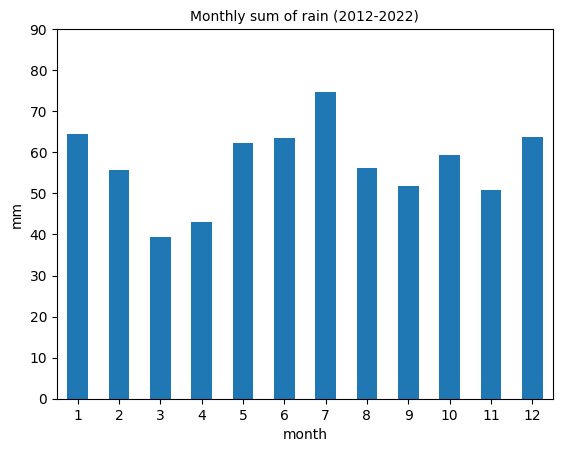

In [39]:
ax = rain.plot.bar(fontsize = 15, y='average_rain', rot=0)
ax.set(ylabel='mm')
ax.set_ylim(top=90) 
ax.set_title("Monthly sum of rain (2012-2022)", fontsize = 10)
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.get_legend().remove()


ax.figure.savefig("../images/average_precip.png",dpi=300)